In [2]:
import os
import sys

spark_home = os.environ['SPARK_HOME']
print spark_home
sys.path.insert(0, spark_home + "/python/")
sys.path.insert(0, os.path.join(spark_home, 'python/lib/py4j-0.8.2.1-src.zip'))

# Initialize PySpark to predefine the SparkContext variable 'sc'
execfile(os.path.join(spark_home, 'python/pyspark/shell.py'))

/home/taddy/lib/spark
Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 1.6.0-SNAPSHOT
      /_/

Using Python version 2.7.10 (default, May 28 2015 17:02:03)
SparkContext available as sc, SQLContext available as sqlContext.


Function to read the csv data lines

In [3]:
import csv
import StringIO
from pyspark.mllib.regression import LabeledPoint

def loadRecord(line):
    """Parse a CSV line"""
    input = StringIO.StringIO(line)
    reader = csv.reader(input)
    row = map(float, reader.next())
    return LabeledPoint(row[-1],row[:-1]) 


And a bunch of functions to translate from the MLLIB DebugString to a nice dot file.

In [4]:
import re
from IPython.display import Image

def tree2dict(tstr, covariates, i=0):
    m = re.search(r"Predict: (-*\d+.\d+)", tstr[i])
    if m is not None:
        return {i-1:round(float(m.group(1)),2)}
    else:
        m = re.search(r"If \(feature (\d+) <= (-*\d+.\d+)", tstr[i])
        if m is not None:
            label = covariates[int(m.group(1))] + ' > ' + m.group(2)
            left = i + 1
            right = [re.search(
                    "Else \(feature %s > %s"%(m.group(1),m.group(2)),t)
                     for t in tstr]
            right = [j for j,r in enumerate(right) if r is not None and j > i][0]+1
            return {i-1:{
                    'label':label, 
                    'left':tree2dict(tstr,covariates,left), 
                    'right':tree2dict(tstr,covariates,right)}}
        else:
            if i < len(tstr)-1:
                return tree2dict(tstr,covariates,i+1)

def writenode(t,fout):
    i = t.keys()[0]
    if type(t[i]) is float:
        fout.write('%d [label = "%.2f", shape="oval", color="darkgreen"] ;\n'%(i,t[i]))
    else:
        fout.write('%d [label = "%s", shape="box", color="brown"] ;\n'%(i,t[i]['label']))
        fout.write('%d -> %d ;\n'%(i,t[i]['left'].keys()[0]))
        fout.write('%d -> %d ;\n'%(i,t[i]['right'].keys()[0]))
        writenode(t[i]['left'],fout)
        writenode(t[i]['right'],fout)

def showtree(tree, covariates, name="tree"):
    tstr = tree.toDebugString().strip("\n").split("\n")
    fout = open("%s.dot"%name,'w')
    tdict = tree2dict(tstr, covariates)
    fout.write("digraph Tree {\n")
    writenode(tdict,fout)
    fout.write("}\n")
    fout.close()
    os.system("dot -Tpng %s.dot -o %s.png"%(name,name))


Read the data

In [5]:
data = sc.textFile("data/CAhousing.csv")
header = data.first() 
data = data.filter(lambda x:x !=header)   
data = data.map(loadRecord)
data.persist()

var = header.split(",")
for i,j in enumerate(var):
    print "%d: %s" % (i,j)

n = data.count()
print "\n", n, "observations like", data.first()


0: longitude
1: latitude
2: housingMedianAge
3: totalRooms
4: totalBedrooms
5: population
6: households
7: medianIncome
8: medianHouseValue

20640 observations like (452600.0,[-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252])


In [6]:
# Train a DecisionTree model.
from pyspark.mllib.tree import DecisionTree

#  Empty categoricalFeaturesInfo indicates all features are continuous.
cahtree = DecisionTree.trainRegressor(data, categoricalFeaturesInfo={},
                                    impurity='variance', minInstancesPerNode=3500)

print cahtree.toDebugString()

DecisionTreeModel regressor of depth 3 with 9 nodes
  If (feature 7 <= 5.0151)
   If (feature 7 <= 3.0645)
    If (feature 1 <= 35.22)
     Predict: 154948.70910007562
    Else (feature 1 > 35.22)
     Predict: 115452.57131681878
   Else (feature 7 > 3.0645)
    If (feature 2 <= 26.0)
     Predict: 186765.23662048357
    Else (feature 2 > 26.0)
     Predict: 225220.9203821656
  Else (feature 7 > 5.0151)
   Predict: 329163.1549359118



If you re-run each tree will be slightly different because for continuous inputs spark splits on 32 quantiles of a random subsample of data.

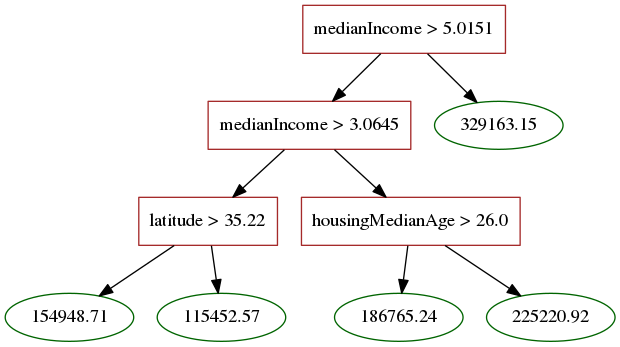

In [7]:
showtree(cahtree, var, "cahtree")
Image(filename="cahtree.png")

Now, get observation predictions and node memberships.

In [9]:
yhat = cahtree.predictWithID(data.map(lambda x: x.features))


AttributeError: 'DecisionTreeModel' object has no attribute 'predictWithID'

In [7]:



labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions)
testMSE = labelsAndPredictions.map(lambda (v, p): (v - p) * (v - p)).sum() / float(testData.count())
print('Test Mean Squared Error = ' + str(testMSE))
print('Learned regression tree model:')
print(model.toDebugString())
dir(model)

['__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_java_loader_class',
 '_java_model',
 '_load_java',
 '_sc',
 'call',
 'depth',
 'load',
 'numNodes',
 'predict',
 'save',
 'toDebugString']

In [8]:
model.toDebugString

<bound method DecisionTreeModel.toDebugString of DecisionTreeModel regressor of depth 3 with 9 nodes>

In [9]:
from pyspark.mllib.tree import RandomForest, RandomForestModel
forest = RandomForest.trainRegressor(trainingData, categoricalFeaturesInfo={},
                                     numTrees=20, featureSubsetStrategy="all",
                                     impurity='variance', maxDepth=3)


In [10]:
trees = forest._java_model.trees()